<a href="https://colab.research.google.com/github/mcnica89/Markov-Chains-RL-W24/blob/main/SARSA_and_Q_learning_on_Gamblers_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# True Solution Using Value Iteration

(Note that this assumes you know the true probabilies!)



Iteration number:  0


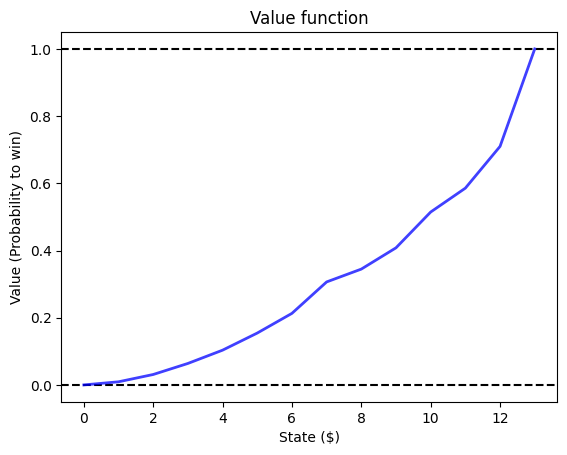

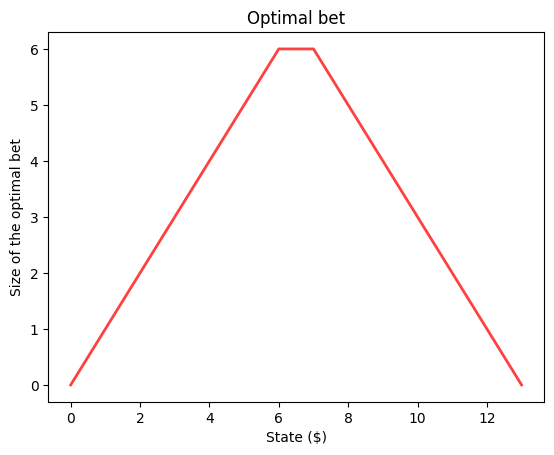

In [ ]:
#Code these as global variables to match textbook notation for inputs to functions
P_HEADS = 0.3
N_TARGET = 13

def plot_value_function_and_actions_v(v_star, a_star):
  #Purpose:
  #  Plot v_star and a_star for the Gambler's problem
  #Output:
  #  A plot of the simple random walks


  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  ax.axhline(0,color='black',linestyle='dashed')
  ax.axhline(1,color='black',linestyle='dashed')
  ax.set_title("Value function")
  ax.set_xlabel("State ($)")
  ax.set_ylabel("Value (Probability to win)")

  #ax.set(ylim=(-2*math.sqrt(N_steps),2*math.sqrt(N_steps)))

  #print("Generating random walks....")
  #random_walks = generate_simple_random_walk(random_key,N_steps,N_samples)
  #print("Plotting random walks....")
  ax.plot(v_star,linewidth=2, alpha=0.75, color='blue')  # Plot some data on the axes.

  fig2, ax2 = plt.subplots()  # Create a figure containing a single axes.
  ax2.set_title("Optimal bet")
  ax2.set_xlabel("State ($)")
  ax2.set_ylabel("Size of the optimal bet")


  ax2.plot(a_star,linewidth=2, alpha=0.75, color='red')  # Plot some data on the axes.

  plt.show()


def gamblers_problem_matrix(p_heads,N_target):
  '''return a matrix for what happesn int the gamblers problems'''
  P = np.zeros((N_target+1,N_target+1,N_target+1))
  #P(i,j,a) is the probabilty to go from state i to state j when you bet a
  i,j,a = np.indices(P.shape)
  first_row = (i==0)
  last_row = (i==N_target)
  first_or_last_row = np.logical_or(first_row,last_row)
  inbetween_row = np.logical_not(first_or_last_row)
  maximum_bet_size_ok = np.logical_and(a<=i, a<=N_target-i)
  allowed_to_bet = np.logical_and(inbetween_row, maximum_bet_size_ok)
  P[np.logical_and(i+a==j, allowed_to_bet)] = p_heads
  P[np.logical_and(i-a==j, allowed_to_bet)] = 1-p_heads
  P[np.logical_and(i==j,np.logical_not(allowed_to_bet))] = 1
  return P

def gamblers_problem(p_heads, N_target, num_iters=10, loops=False):
  '''Given the gamblers problem, find the optimal value function v_star
     and the optimal action a_star at any given state s'''

  v_star = np.zeros(N_target+1) #An array with the optimal values
  v_star[N_target] = 1 #Initialize known values at s=N_target and s=0
  v_star[0] = 0

  a_star = np.zeros(N_target+1) #An array with the optimal betting size
  #The s-th component represent the value at s

  q_star = np.zeros((N_target+1,N_target+1))
  #q_star(s,a) is the value function if you play action a from state s
  # and then play optimally afterwards
  # The s-th, a-th etnry of q_star represents q_star(s,a)
  # Be careful! q_star(s,a) only makes sense if a is less than max_bet at s
  # Max_bet(s) = min(s,N_target-s)

  P = gamblers_problem_matrix(p_heads,N_target)

  for iteration in range(num_iters):
    if iteration % 100 == 0:
      print("Iteration number: ", iteration)

    if not loops:
      q_star = np.einsum( 'sja,j->sa' ,P,v_star)
      v_star = np.max(q_star,axis=1)
      a_star = np.argmax(q_star,axis=1)
    else:
    #Loop way:
    #plot_value_function_and_actions(v_star,a_star)
      for s in range(0,N_target): #Loop through all states
        max_bet = np.minimum(s, N_target-s )
        for a in range(1,max_bet+1): #Loop through all allowed actions
          q_star[s,a] = p_heads*v_star[s+a] + (1-p_heads)*v_star[s-a]
          v_star[s] = np.max(q_star[s,:])
          a_star[s] = np.argmax(q_star[s,:])

  plot_value_function_and_actions_v(v_star,a_star)
  return v_star, a_star

V_TRUE, A_TRUE = gamblers_problem(P_HEADS, N_TARGET, 100)

# Using TD learning for the Q function

In [ ]:
def plot_value_function_and_actions(v_star, a_star):
  #Purpose:
  #  Plot v_star and a_star for the Gambler's problem
  #Output:
  #  A plot of the simple random walks


  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  ax.axhline(0,color='black',linestyle='dashed')
  ax.axhline(1,color='black',linestyle='dashed')
  ax.set_title("Value function")
  ax.set_xlabel("State ($)")
  ax.set_ylabel("Value (Probability to win)")

  #ax.set(ylim=(-2*math.sqrt(N_steps),2*math.sqrt(N_steps)))

  #print("Generating random walks....")
  #random_walks = generate_simple_random_walk(random_key,N_steps,N_samples)
  #print("Plotting random walks....")
  ax.plot(v_star,linewidth=2, alpha=0.75, color='blue')  # Plot some data on the axes.

  fig2, ax2 = plt.subplots()  # Create a figure containing a single axes.
  ax2.set_title("Optimal bet")
  ax2.set_xlabel("State ($)")
  ax2.set_ylabel("Size of the optimal bet")


  ax2.plot(a_star,linewidth=2, alpha=0.75, color='red')  # Plot some data on the axes.

  plt.show()

In [ ]:
def gamblers_problem_nextstate(p_win, current_state, action):
  '''Returns the next state (its random!) given the current_state and action you chose'''

  #p_win is a secret number (unknown to the SARSA user) that is your probability to win
  win = (np.random.rand() < p_win)
  if win == True:
    return int(current_state + action)
  else:
    return int(current_state - action)


In [ ]:
def gamblers_problem_epsilon_greedy(s, q, N_target, epsilon):
  '''Return the action dertermined from the q function from current_state using the epsilon-greedy algorthm'''
  #This sis the line from the pseudocode that says "Choose A from S using policy derived from Q (e.g. epsilond greedy)"

  probability_epsilon_event = bool(np.random.rand() < epsilon)

  max_bet =  int(min(int(s),int(N_target-s)))

  if s == 0:
    return 0
  elif s==N_target:
    return 1 #Handles the corner case when max_bet would be 0

  if probability_epsilon_event == True:
    return int(np.random.randint(1,int(max_bet+1))) #Purely random
  else:
    return np.argmax(q[s,1:max_bet+1])+1 #Purely greedy

In [ ]:
np.random.randint(1,np.float64(6.121))

5

In [ ]:
def gamblers_problem_greedy(s, q, N_target):
  max_bet =  min(s,N_target-s)
  if s == 0:
    return 0
  elif s==N_target:
    return 1 #Handles the corner case when max_bet would be 0
  else:
    return np.argmax(q[s,1:max_bet+1])+1 #Purely greedy

In [ ]:
def gamblers_problem(p_heads, N_target, num_episodes=10):
  '''Return the optimal value function and optimal policy for Gamblers problem using SARSA'''
  #Note: p_heads is a secret! Not allowed to know the value of p_heads!!!!!
  #q_star = np.random.rand(N_target+1,N_target)
  q_star = np.zeros((N_target+1,N_target))
  for s in range(N_target+1):
    for a in range(1,N_target):
      if a <= min(s,N_target-s):
        q_star[s,a] = 0 #np.random.rand()

  #q_star(s,a) is the value function if you play action a from state s
  # and then play optimally afterwards
  # The s-th, a-th entry of q_star represents q_star(s,a)
  # Be careful! q_star(s,a) only makes sense if a is less than max_bet at s
  # Max_bet(s) = min(s,N_target-s)

  #Hardcode the fact that the reward at N_target is 1
  q_star[N_target,:] = 1
  q_star[0,:] = 0

  for episode in range(num_episodes):
    if episode % int(num_episodes/10) == 0:
      print("Iteration number: ", episode)
    epsilon = 2/( (episode+1)**(0.33333) )
    learning_rate = 1 / (episode+1)**(0.3333)
    current_state = random.randint(1,N_target-1)

    while current_state > 0 and current_state < N_target:

      #Get the new action from q_star
      #current_action = gamblers_problem_greedy(current_state, q_star, N_target)
      current_action = gamblers_problem_epsilon_greedy(current_state, q_star, N_target,epsilon)

      #Sample the new state
      new_state = gamblers_problem_nextstate(p_heads, current_state, current_action)
      reward = 0 #The reward is always 0 in the Gambler's problem except for the terminal state at N_target

      #Choose which update rule you want!!!

      #Q-LEARNING UPDATE RULE
      v_star = np.max(q_star[:,1:],axis=1)
      q_star[current_state,current_action] += learning_rate*(reward+v_star[new_state] - q_star[current_state,current_action])

      #SARSA UPDATE RULE
      #new_action = #gamblers_problem_greedy(new_state, q_star, N_target)
      #new_action = gamblers_problem_epsilon_greedy(new_state, q_star, N_target, epsilon)
      #q_star[current_state,current_action] += learning_rate*(reward+q_star[new_state,new_action] - q_star[current_state,current_action])


      current_state = new_state

  v_star = np.max(q_star[:,1:],axis=1)
  a_star = np.argmax(q_star[:,1:],axis=1)+1
  plot_value_function_and_actions(v_star,a_star)
  plt.plot(V_TRUE-v_star)
  plt.title("Difference with True Answer")
  return v_star, a_star

Iteration number:  0
Iteration number:  10000
Iteration number:  20000
Iteration number:  30000
Iteration number:  40000
Iteration number:  50000
Iteration number:  60000
Iteration number:  70000
Iteration number:  80000
Iteration number:  90000


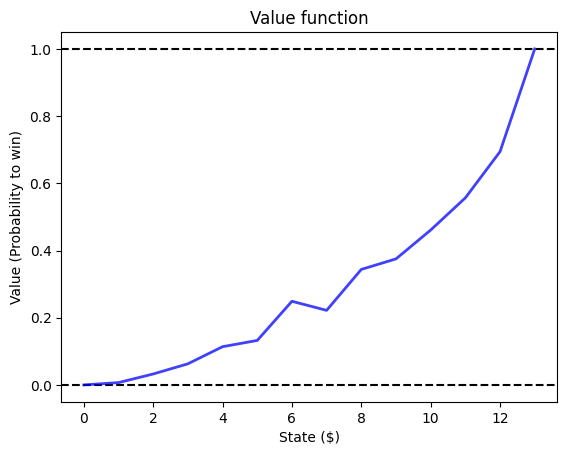

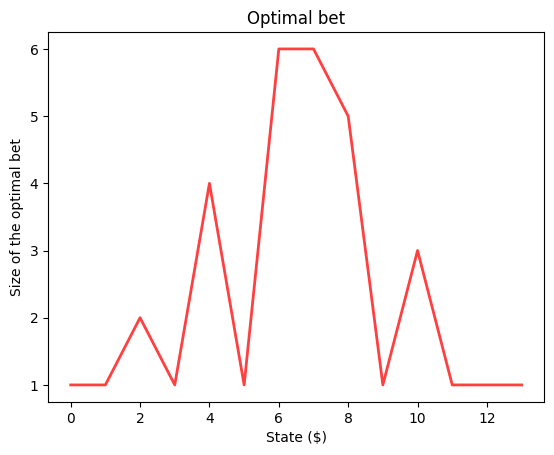

(array([0.        , 0.00693274, 0.03252493, 0.06281079, 0.11375614,
        0.13240896, 0.24892793, 0.22194538, 0.34377135, 0.37513235,
        0.46094026, 0.55678352, 0.6943446 , 1.        ]),
 array([1, 1, 2, 1, 4, 1, 6, 6, 5, 1, 3, 1, 1, 1]))

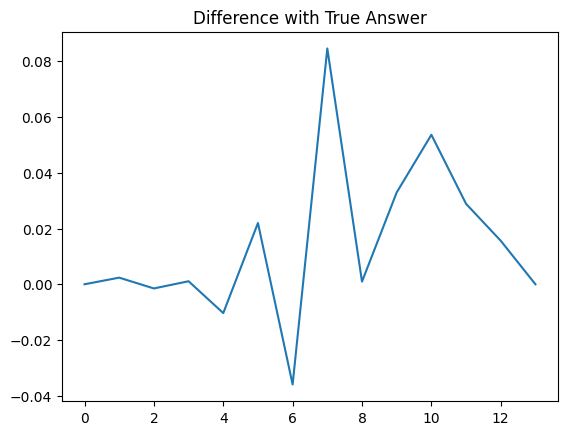

In [ ]:
gamblers_problem(0.3, 13, 100000)

In [ ]:
random.random()

0.806607429088645